# HMM

<img src='hmm.png' width=100/>

## Скрытые Марковские модели

## Первая часть

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from Bio import SeqIO
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Так получается, что в python не очень-то реализованы алгоритмы для скрытых марковских моделей - те пакеты, которые есть, не очень-то работают(это судьба большей части пакетов на python). В случае HMM это происходит из-за того, что есть numpy, с помощью которого средний программист может быстро сделать себе марковскую цепь и pymc3 - чудовищный по своим возможностям пакет байесовского статистического моделирования.

Попробуем построить свою скрытую марковскую модель на реальных данных.  
Возьмем геном бактерии Helicobacter pylori(Это такая тварь, которая имеет тенденцию поселяться в желудке человека и давать много побочных эффектов. Её наличие служит хорошим индикатором серьезных проблем с пищеварительной системой).

Модель построим такую:

Будем размечать гены и незначимые ORF двумя состояниями.
Нам понадобится матрица переходов между состояниями и для каждого состояния распределение встречаемости нуклеотидов.

Упражнение будем совершать на основе Helicobacter Pilori.  
Для получения исходных данных для разметки сделаем следующее:
1. Скачаем геном
2. Воспользуемся EasyGene для того, чтобы получить GFF-файл с разметкой генома.

Берём для ориентира сборку AE000511.1(https://www.ncbi.nlm.nih.gov/nuccore/AE000511.1?report=fasta) в формате FASTA.

In [2]:
!head ./GCA_000008525.1_ASM852v1_genomic.fna -n 1

>AE000511.1 Helicobacter pylori 26695, complete genome


В GFF-файле(описание GFF http://www.cbs.dtu.dk/services/EasyGene/output.php) каждая строка - это описание гена. 
И в столбцах start и end - начало и конец значимых участков генома.

Для того, чтобы подсчитать распределение вероятности эмиссии в разных состояниях, нам нужно подсчитать встречаемость тринуклеотидов в каждом состоянии. Для этого надо выбрать последовательности из gff файла и подсчитать встречаемость в них и потом сделать то же самое для остальных частей генома.

Сохраним их в переменную E - numpy массив.

In [3]:
fasta_file = 'GCA_000008525.1_ASM852v1_genomic.fna'
gff_file = 'genes.gff'
data = pd.read_csv(gff_file, delimiter='\t', sep='/t', skiprows=5) # пропуск метаинформации из EasyGene

In [4]:
data.sort_values('start', inplace=True)

In [5]:
# загруз сиквенса
fasta = SeqIO.parse(fasta_file, "fasta")

for rec in fasta:
    seq = str(rec.seq).upper()

**gff в индексации слайсов включает конец, индексация с 1, значит отнимем от колонки start 1**

минус-направление это на другой цепи днк, значит, чтобы получить сиквенс гена, надо повернуть и откомплиментарить,
но он нам не нужен

In [6]:
genes = data[['start', 'end']]
genes['start'] -= 1
genes.head()

,start,end
733,216,633
734,634,1105
735,1114,1945
736,1931,2597
0,2718,3402


In [7]:
f'{genes.shape[0]} - the number of genes'

'1532 - the number of genes'

In [8]:
pd.Series(genes.start.values[1:] > genes.end.values[:-1]).value_counts()

True     1191
False     340
dtype: int64

**340 перекрытий генов**

In [10]:
Gene_space = [] # это список индексов всех букв, которые в генах
for s in genes.values:
    Gene_space += list(range(s[0],s[1]))
AllGeneSpaseId = len(Gene_space)
Gene_space = set(Gene_space) # каких-то индексов несколько из-за перекрытия
Non_gene_space = sorted(set(np.arange(len(seq))) - Gene_space) # остальные индексы это не гены
Gene_space = sorted(Gene_space)

if len(Non_gene_space) + len(Gene_space) == len(seq):
    print(f'~{round(len(Gene_space) / len(seq) * 100, 2)}% всех нуклеотидов под генами')
    print(f'{AllGeneSpaseId - len(Gene_space)} нуклеотидов, которые более чем в одном гене')

~89.78% всех нуклеотидов под генами
3621 нуклеотидов, которые более чем в одном гене


In [10]:
# Создадим последовательность состояний в виде Series
state_seq = pd.concat([pd.Series([True]*len(Gene_space), index=Gene_space), 
                       pd.Series([False]*len(Non_gene_space), index=Non_gene_space)]).sort_index()
# И в виде массива
is_gene = state_seq.values
len(is_gene) == len(seq)

True

In [11]:
is_gene[630:660]

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [12]:
%%time
# Сделаем табличку с интервалами для не генов. Она такая же как genes
ng = []
st = 0
prev_state = is_gene[0]
for i in range(1, len(seq)):
    cur_state = is_gene[i]
    if prev_state != cur_state and cur_state == True:
        end = i
        ng.append([st, end])
    if prev_state != cur_state and cur_state == False:
        st = i
    prev_state = cur_state
ng.append([st,len(seq)])

CPU times: user 8.47 s, sys: 4.13 ms, total: 8.47 s
Wall time: 8.47 s


In [13]:
non_genes = pd.DataFrame(ng, columns=['start', 'end'])
non_genes.head(3)

,start,end
0,0,216
1,633,634
2,1105,1114


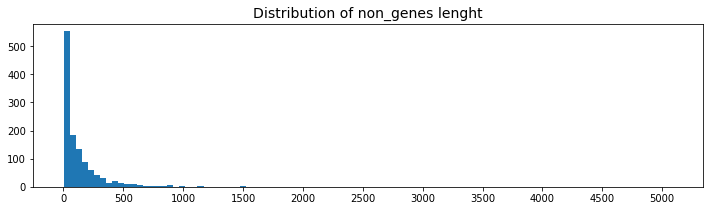

In [14]:
# Распределение длин не генов
plt.figure(figsize=(12, 3))
_ = plt.hist(non_genes.end - non_genes.start, bins=100)
plt.title('Distribution of non_genes lenght', fontsize=14)
_ = plt.xticks(np.arange(0, 5001, 500))

Около нуля очень много. Удалим те не гены, длина которых не больше 10, чтоб не загрязнять данные о не генах: на 10 буквах частоты совсем рандомные

In [15]:
non_genes['seq_len'] = non_genes.end - non_genes.start

In [16]:
len(non_genes)

1193

In [17]:
non_genes = non_genes[non_genes.seq_len > 10]
len(non_genes)

939

Несколько функций для счета частот k-меров

In [18]:
def make_kmers_list(k, temp_d=['A','T','G','C']):
    '''recursively creates list of all dna k-mers'''
    if k == 1:
        return temp_d

    new_temp = []
    for x in temp_d:
        for w in ['A','T','G','C']:
            new_temp.append(x + w)
    temp_d = make_kmers_list(k-1, new_temp)
    return temp_d

def kmer_dict(seq, k=3):
    '''creates dict where keys are kmers and values are frequences of these kmers in the seq;
       pass not determined nucleotides'''
    keys = make_kmers_list(k)
    seq = seq.upper()
    len0 = len(seq)
    freq_dict = dict(zip(keys,np.zeros(len(keys))))
    onee = 1 / len0
    
    for i in range(len0 - 3):
        tripl = seq[i:i+k]
        cond = True
        for N in set(tripl):
            if N not in 'ATGC':
                cond = False
        if cond:
            freq_dict[tripl] += onee
    return freq_dict

def count_proba(start_ends, seq, k=3):
    '''counts probabilities of each k-mer occurence
    Выплевывает:
    1. словать с частотами (в следующей функции будет это использоваться)
    2. матрицу частот
    3. список всех k-меров, чтобы матрица имела смысл
    '''
    big_seq = ''
    for x in start_ends.values:
        local_seq = seq[x[0]: x[1]]
        big_seq += local_seq # make one big seq

    freqs = kmer_dict(big_seq, k)
    return freqs, list(freqs.values()), list(freqs.keys())

In [19]:
E_genes_dict, E_genes, alphabet_set = count_proba(genes, seq)
E_nongenes_dict, E_nongenes, _ = count_proba(non_genes, seq)

In [20]:
# Emission dict and matrix
Edict = np.array([E_genes_dict, E_nongenes_dict])
E = np.array([E_genes, E_nongenes])

In [21]:
Edict[0]['AAA'], Edict[1]["AAA"]

(0.05439781273538545, 0.07312325460310048)

In [22]:
sum(Edict[0].values()), sum(Edict[1].values())

(0.9999660238509505, 0.9995503384294656)

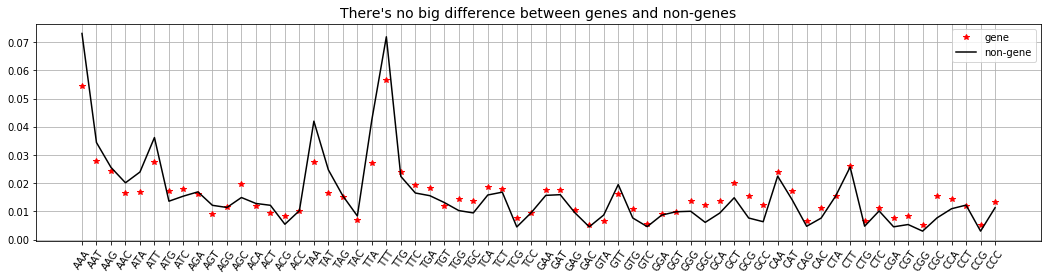

In [23]:
# График частот всех триплетов для генов и не генов. Разница есть, но не много
plt.figure(figsize=(18, 4))
for em,c,l in zip(Edict, ['r*','k'],['gene','non-gene']):
    plt.plot(em.keys(), em.values(), c, label=l)
plt.legend()
plt.xticks(rotation=55)
plt.grid(True)
_ = plt.title("There's no big difference between genes and non-genes", fontsize=14)

И матрица вероятностей переходов между состояниями $\LARGE a_{kl} = \frac{A_{kl}}{\sum_i A_{ki}}$ - количество раз, когда одно состояние сменялось другим:

In [24]:
# A = [[1 в 1, из 1 в 2],
#      [2 в 1, из 2 в 2]]
# 1 - genes
# 2 - non_genes

In [25]:
A = np.array([[len(Gene_space) - genes.shape[0], genes.shape[0]],
              [non_genes.shape[0] - 1, len(Non_gene_space) - non_genes.shape[0]]])
A

array([[1495900,    1532],
       [    938,  169496]])

In [26]:
A.sum(), len(seq), (len(seq) - A.sum()), 'так и должно быть: переходов меньше на 1, т.к. последний нуклеотид не переходит'

(1667866,
 1667867,
 1,
 'так и должно быть: переходов меньше на 1, т.к. последний нуклеотид не переходит')

In [27]:
A = A / [[len(Gene_space)], 
         [len(Non_gene_space)]]
A, A.sum()

(array([[0.99897692, 0.00102308],
        [0.00550356, 0.99449057]]), 1.9999941326605453)

----

## Вторая часть.

Попробуем посчитать правдоподобие данной строки по формуле:
$$ \LARGE P(X, \pi ) = P(x_1, \dots, x_n, \pi_1, \dots, \pi_n) = P(X_N|\pi_N)P(\pi_N|\pi_{N-1})\dots  P(X_2|\pi_2)P(\pi_2|\pi_1)P(X_1|\pi_1)P(\pi_1) $$

$$\LARGE =a_{_0\pi_1}a_{\pi_1\pi_2} \dots a_{\pi_{N-1}\pi_{N}} e_{\pi_1}(x_1)\dots e_{\pi_N}(x_N) $$

(Аккуратно перемножить для каждого символа из строки $e$ для него, умножая каждый раз на вероятность $a$, которая соответствует текущему состоянию. Например: мы идём по участку интрона, встречаем тимин и умножаем вероятность встретить тимин на вероятность для текущего и предыдущего символа быть в интроне(т.к. мы идём по интрону, то предыдущий и текущий символ у нас - части интрона - умножаем на вероятность перехода из интрона в интрон. И конечно, берем от всего этого логарифм, заменяя произведение суммой)

$\mathbf{a}$ и $\mathbf{e}$ мы уже подсчитали в предыдущем пункте.

**Так как вероятности триплетов мы считали пробегаясь окном с шагом 1, будем так же считать правдоподобие**

In [28]:
def proba(seq, state_seq, E, A, k=3):
    ''' Она считает правдоподобие
    seq - DNA sequence
    A - transition matrix
    E - emission list with dicts of kmers in keys
    state_seq - state sequence 
    k - used kmer lenght 
    '''
    first_kmer = seq[:k]
    previous_state = state_seq[0]
    log_sum = np.log(E[int(not previous_state)][first_kmer]) # init with only E_matrix value;
#     not previous_state здесь значит индексацию. Т.е. в начале у нас не ген(False), но 
#     в матрицах на первых позициях генные вероятности, а False это 0, который мы заменяем на 1
    pass_counter = 0
    for i in range(1, len(seq)-(k-1)):
        if len(set(state_seq[i: i+k])) > 1:
            pass_counter += 1
            continue # pass pre_end triplets of genes(nongenes), which include end_index and contain both states
        
        cur_kmer = seq[i: i+k]        
        if not np.all([N in 'ATGC' for N in cur_kmer]):
            pass_counter += 1
            continue # pass the triplets with unknown nucleotides
            
        cur_state = state_seq[i]
        state_changed = cur_state != previous_state
        XNOR_id = cur_state * state_changed + (not cur_state) * (not state_changed) # эта переменная тоже 
#         за индексацию отвечает, в trans_matrix. XNOR из-за вида матрицы, ну и чтоб 1 строчкой записать
#         и не городить много if'ов
        
        e = np.log(E[int(not cur_state)][cur_kmer])
        a = np.log(A[int(not cur_state), int(XNOR_id)])

        log_sum += e + a
    print(f'{pass_counter} passed\n')
    return np.exp(log_sum)

In [29]:
%%time
proba(seq, is_gene, Edict, A)

4853 passed

CPU times: user 1min 5s, sys: 8.35 ms, total: 1min 5s
Wall time: 1min 5s


0.0

In [30]:
f'{proba(seq[:100], np.zeros(100), Edict, A)} это вероятность того, что начало сека это не ген'

0 passed



'1.3602189968286137e-172 это вероятность того, что начало сека это не ген'

In [31]:
f'{proba(seq[:100], np.ones(100), Edict, A)}, а это вероятность того, что начало сека это ген'

0 passed



'4.6723163890326694e-175, а это вероятность того, что начало сека это ген'

**А так как известно, что начало это не ген, то правдоподобие как будто бы работает! Однако на таких малых вероятностях дальше пары сотен нуклеотидов не уедешь, все обращается в 0, а длина генов обычно больше 300 букв**

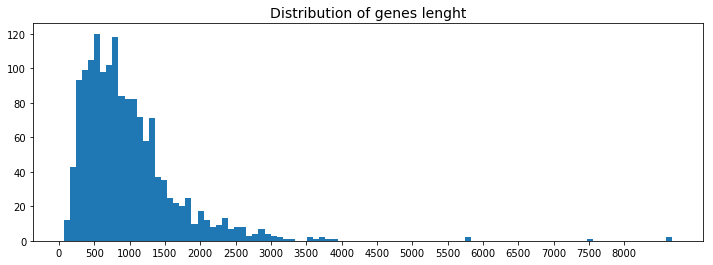

In [32]:
# Распределение длин генов
plt.figure(figsize=(12, 4))
_ = plt.hist(genes.end - genes.start, bins=100)
plt.title('Distribution of genes lenght', fontsize=14)
_ = plt.xticks(np.arange(0, 8001, 500))

Результат - число - будет обозначать, насколько вероятно было встретить такую последовательность символов при таких вероятностях встретить символы при соответствующих состояниях.

Зачем такое может понадобиться? Например, мы построили модель по одному организму, для которого известна только часть генома. Для новых частей генома мы можем получить оценку правдоподобия - чем выше оценка, тем больше вероятность того, что новая часть генома действительно относится к изучаемому организму.

## Третья часть.

Попробуем сделать алгоритм Витерби, который по последовательности считает наиболее вероятную последовательность состояний.  
Подробнее вот тут: https://drive.google.com/open?id=1v4V8NXjEkjTrcZhuPd3j0_1Hh3kmxWPK  
Идея такая -- нужно пройти по входной последовательности и брать каждый раз максимально возможную комбинацию состояния и наблюдаемого символа.

Т.е. начинаем с фиктивного нулевого состояния и выбираем максимальную вероятность получения очередного символа последовательности из каждого состояния и далее по рекуррентному соотношению: $ \LARGE V_l (i+1) = e_l \max_{k} a_{kl}V_k(i)$

In [33]:
def Viterbi(seq, A, E, S='GN', I=None, k=3):
    
    '''realisation of Viterbi algirithm looking at Wiki pseudocode
    A - transition matrix
    E - emission list with dicts of kmers in keys
    I - init matrix with probas for gene and non_gene, accordingly
    S - state set
    k - kmer lenght
    
    returns
    X - sequence of states
    '''
    K = len(A)
    I = I or np.full(K, 1 / K)
    N = len(E[0])
    T = len(seq) - (k-1)
    T1, T2 = np.zeros((K,T)), np.zeros((K,T), dtype=int)
    first_kmer = seq[:k]
    for i in range(K):
        T1[i,0] = I[i] * E[i][first_kmer]

    for i in range(1, T):
        cur_kmer = seq[i:i+k]
        for j in range(K):
            variants = [T1[t, i-1] * A[t][j] * E[j][cur_kmer] for t in range(K)]
            T1[j,i] = np.max(variants)
            T2[j,i] = np.argmax(variants)
            
    Z = np.zeros(T,dtype=int)
    Z[-1] = np.argmax(T1[:,T-1])
    for i in reversed(range(1, T)):
        Z[i-1] = T2[Z[i], i]
    X = ''.join([S[i] for i in Z])
    X += X[-1] * (k-1)

    return X

In [34]:
Viterbi(seq[100:200], A, Edict)

'NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN'

In [35]:
Viterbi(seq[2750:2950], A, Edict)

'GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG'

In [36]:
Viterbi(seq[8602:9267], A, Edict)

'GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG'

In [37]:
non_genes.values[6], genes.values[7],

(array([12639, 12727,    88]), array([7602, 9243]))

**Не классифицирует на состояния правильно, т.к. разницы меж ними мало. Проверка на других организмах бесполезна**

Проверка алгоритма на сете из розалинда

In [38]:
y = 'xyxzzxyxyy'
A = np.array([[0.641, 0.359],
              [0.729, 0.271]])
B = np.array([[0.117, 0.691, 0.192], 
             [0.097, 0.42, 0.483]])
Bdict = [dict(x=0.117, y=0.691, z=0.192), 
         dict(x=0.097, y=0.42, z=0.483)]

enc = LabelEncoder()
tra_y = enc.fit_transform(list(y))

In [39]:
Viterbi(y, A, Bdict, k=1, S='AB'), 'работает ладно'

('AAABBAAAAA', 'работает ладно')

----

## Четвертая часть.

Библиотека hmmlearn.  
Документация: https://hmmlearn.readthedocs.io/en/latest/
Должна без проблем импортироваться. Если не импортируется, то
```
pip3 install hmmlearn
```

In [40]:
from hmmlearn import hmm
import numpy as np

По какой-то причине не существует очень хороших пакетов на тему скрытых марковских моделей. В принципе при наличии особого желания можно написать свой(все так делают, поэтому в pip так много пакетов) с помощью numpy написать алгоритмы Витерби, прямого и обратного вычисления и Баума-Уэлша.

На момент создания домашки hmmlearn поддерживает 3 типа скрытых марковских моделей:  
1. hmm.GaussianHMM - наблюдаемые состояния генерируются нормальным распределением.
2. hmm.GMMHMM - наблюдаемые состояния генерируются смесью нормальных распределений.
3. hmm.MultinomialHMM - наблюдаемые состояния - дискретное распределение.

##### hmm.GaussianHMM
Как это и зачем это?
Допустим, мы бежим скользящим окном по геному, как мы это делали в аудитории на одной из лабораторных и для каждого окна считаем GC-content. Если зажмуриться и считать, что gc-content распределен нормально, то для экзона распределение этого параметра будет одним, а для интрона - другим.

Вообразим себе такую систему, которая будет переключаться между двумя состояниями, и в каждом выдавать числа из отдельного нормального распределения.

In [58]:
model = hmm.GaussianHMM(n_components=2, covariance_type="full") # два состояния
model.startprob_ = np.array([0.5, 0.5]) # вероятности стартовать из каждого состояния, в сумме ноль.
model.transmat_ = np.array([[0.8, 0.2], 
                             [0.2, 0.8]]) # для каждого состояния вероятность перейти в соответствующее состояние
model.means_ = np.array([[0.0], [3.0]]) # стартовые средние
model.covars_ = np.tile(np.identity(1), (2, 1, 1)) # стартовые дисперсии
X, Z = model.sample(10) # по параметрам генерируем пары 

Наблюдаемые числа:

In [59]:
X

array([[ 3.69147273],
       [ 1.45691149],
       [ 2.41519746],
       [ 4.43658706],
       [-1.50367   ],
       [-1.48327046],
       [-0.42403175],
       [ 0.81033224],
       [ 2.4465341 ],
       [ 2.95714422]])

Наблюдаемые состояния:

In [60]:
Z

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1])

Размерность выкидываемого распределения определяется автоматически. Можно сделать, например так:

In [61]:
model = hmm.GaussianHMM(n_components=2, covariance_type="full") # два состояния
model.startprob_ = np.array([0.5, 0.5]) # вероятности стартовать из каждого состояния, в сумме ноль.
model.transmat_ = np.array([[0.7, 0.3], 
                             [0.2, 0.8]]) # для каждого состояния вероятность перейти в соответствующее состояние
model.means_ = np.array([[-3, -3 ], [3.0, 3]]) # стартовые средние - а сейчас зададим двумерные.
model.covars_ = np.tile(np.identity(2), (2, 1, 1)) # стартовые дисперсии вида [1,1]
X, Z = model.sample(100) # по параметрам генерируем пары 

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

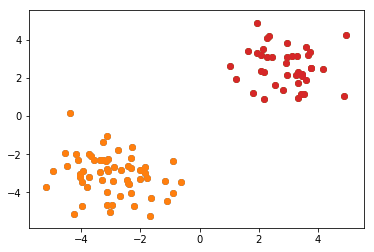

In [63]:
for state in np.unique(Z):
    plt.scatter(X[:,0][Z==state], X[:,1][Z==state])
    plt.scatter(X[:,0][Z==state], X[:,1][Z==state])
    
plt.show()

Получили двумерные наблюдения.

##### hmm.MultinomialHMM
А тут мы генерируем из состояний дискретные распределения.
Попробуем воспроизвести пример с казино и кубиком, который у нас был в лекции. Он как раз подходит - 2 кости(состояния), и 6 граней в каждой кости(наблюдаемые состояния).

In [64]:
casino_model = hmm.MultinomialHMM(n_components=2)#два кубика

Зададим вероятности:

Т.к. пакеты в python делают очень неспеша и иногда небрежно, в самой последней версии пакета, которую можно установить из pip, есть такой нюанс - в ней для MultinomialHMM по умолчанию не создаются атрибуты для матриц E(emissionprob_), A(transmat_) и стартовой матрицы(startprob_). Они создаются в коде метода fit, который тренирует модель. Поэтому я, минут 10 посмотрев на код, понял, что можно сделать и вот так:

In [65]:
casino_model.emissionprob_ = np.array([[1/6 ]*6, [1/10,1/10,1/10,1/10,1/10,1/2]])
casino_model.startprob_ = np.array([0.5,0.5])
casino_model.transmat_ = np.array([[0.95, 0.05],[0.05, 0.95]])

In [66]:
dice, state  = casino_model.sample(100)

По умолчанию пакет будет выводить состояния от 0 до 5, поэтому +1, чтобы выглядело красиво:

In [67]:
np.squeeze(dice+1)

array([5, 2, 5, 3, 1, 5, 2, 2, 5, 2, 3, 5, 1, 6, 1, 4, 6, 1, 3, 3, 5, 6,
       5, 3, 1, 6, 2, 2, 4, 4, 3, 2, 3, 2, 2, 1, 3, 5, 3, 5, 1, 6, 2, 5,
       6, 2, 6, 6, 6, 1, 5, 5, 6, 6, 6, 6, 3, 6, 2, 6, 3, 5, 2, 5, 6, 6,
       6, 6, 6, 6, 6, 2, 3, 3, 6, 6, 6, 1, 6, 2, 6, 6, 6, 2, 6, 5, 1, 6,
       6, 3, 4, 6, 4, 6, 2, 2, 6, 6, 1, 6])

А это состояния:

In [68]:
state

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

----
Финиш четвертой части.
Бонус для развлечения со звёздочкой - соорудить по матрицам A и E первой части GaussianHMM(метод fit какой-то очень неудобный), который будет для экзона и интрона выдавать разные %GC. 
Т.е.:
1. берем разметку ген/не ген
2. для каждой последовательности скользящим окном не очень большого размера считаем %GC - получаем для каждого участка набор оценок GC, к которому относимся как к нормально распределенному - берем среднее и дисперсию
3. Средние и дисперсии подставляем в hmm.GaussianHMM.
Такая модель в будущем позволит выполнять стандартные для HMM операции:
    * правдоподобие(как раз и будет мера похожести - определять похожесть нового участка ДНК на тот, по которому построена модель и такое сравнение будет отлично от выравниваний по своей механике)
    * decode - для участка ДНК определить наиболее вероятную последовательность состояний, которая привела к появлению наблюдаемой последовательности.

Пара функций для оконного счета ГЦ:

In [41]:
def count_GC(seq):
    return (seq.count('G') + seq.count('C')) / len(seq)

def window_counter(seq, M=True, window=60):
    GCs = [count_GC(seq[i:i+window]) for i in range(0, len(seq), window//2)]
    mean = np.mean(GCs)
    std = np.std(GCs)
    if M:
        return mean
    return std

In [42]:
genes['GC_mean'] = genes.apply(lambda s: window_counter(seq[int(s[0]):int(s[1])]), axis=1)
# genes['GC_std'] = genes.apply(lambda s: window_counter(seq[int(s[0]):int(s[1])], False), axis=1)

non_genes['GC_mean'] = non_genes.apply(lambda s: window_counter(seq[int(s[0]):int(s[1])]), axis=1)
# non_genes['GC_std'] = non_genes.apply(lambda s: window_counter(seq[int(s[0]):int(s[1])], False), axis=1)

In [43]:
GeneM = genes.GC_mean.mean()
GeneS = genes.GC_mean.std()

NongeneM = non_genes.GC_mean.mean()
NongeneS = non_genes.GC_mean.std()

GeneM, NongeneM, GeneS, NongeneS # средние да отклонения стандартные

(0.39111450437897405,
 0.3119003389850036,
 0.03483616870790018,
 0.08306242866157142)

In [44]:
model = hmm.GaussianHMM(n_components=2, covariance_type="full") # два состояния
model.startprob_ = np.array([0.5, 0.5])
model.transmat_ = A
model.means_ = np.array([[GeneM], [NongeneM]]) # стартовые средние
model.covars_ = np.reshape([GeneS, NongeneS], (2,1,1)) # стартовые дисперсии
X, Z = model.sample(200) # по параметрам генерируем пары 

In [45]:
X[:10]

array([[0.44972388],
       [0.20960068],
       [0.10800737],
       [0.50908076],
       [0.25314028],
       [0.58885075],
       [0.44750031],
       [0.13844179],
       [0.4014219 ],
       [0.84512879]])

In [46]:
Z[:10]

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 1])

Попредсказываем на трейновых данных

In [47]:
Xg = genes.GC_mean.values.reshape(-1,1)
Xn = non_genes.GC_mean.values.reshape(-1,1)
len(Xg), len(Xn)

(1532, 939)

In [48]:
pd.Series(model.predict(np.concatenate([Xg,Xn]))).value_counts() # using predict

0    2469
1       2
dtype: int64

In [49]:
logprob,State_sequence = model.decode(np.concatenate([Xg,Xn]))
pd.Series(State_sequence).value_counts() # using decode

0    2469
1       2
dtype: int64

Не признает модель почти ничего, кроме генов

In [50]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

Text(0.5, 1.0, 'Условные плотности средних по GC')

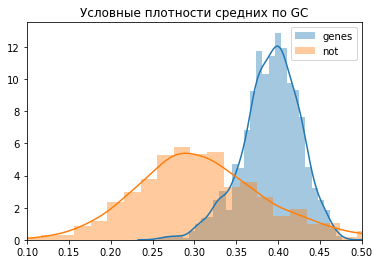

In [51]:
sns.distplot(genes.GC_mean.values, label='genes')
sns.distplot(non_genes.GC_mean.values, label='not')
plt.xlim(.1, .5)
plt.legend()
plt.title('Условные плотности средних по GC')

**Перекрытие серьезное, но ниже от 0.35 до 0.45 хотя бы могла классифицировать, но нет, а таких значений:**

In [52]:
non_genes[(non_genes.GC_mean >= 0.35) & (non_genes.GC_mean <= 0.45)].GC_mean.shape

(214,)

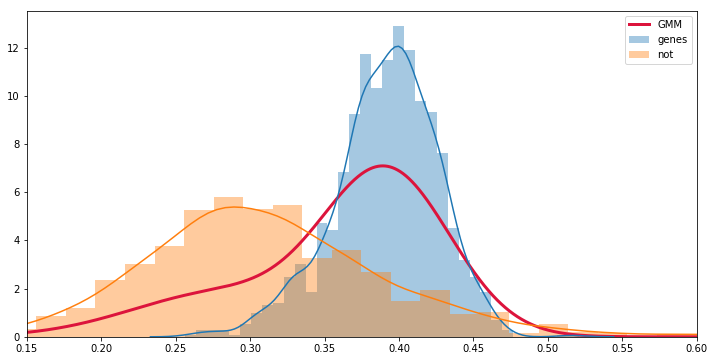

In [53]:
samples = np.random.normal(GeneM, GeneS, 400)
samples = np.append(samples, np.random.normal(NongeneM, NongeneS, 400))
# Fit GMM
GM = GaussianMixture(n_components=2, covariance_type="full", tol=0.001)
# GM.fit(X=np.expand_dims(samples, 1))
# fit on GC of genes and not
GM.fit(X=np.concatenate([genes.GC_mean.values, 
                       non_genes.GC_mean.values]).reshape(-1,1), 
       y=[0]*len(genes) + [1]*len(non_genes))

gmm_x = np.linspace(0, .8, 5000)
gmm_y = np.exp(GM.score_samples(gmm_x.reshape(-1, 1)))

plt.figure(figsize=(12,6))
plt.plot(gmm_x, gmm_y, color="crimson", lw=3, label="GMM")
# sns.distplot(samples, bins=50)
sns.distplot(genes.GC_mean.values,label='genes')
sns.distplot(non_genes.GC_mean.values, label='not')
plt.xlim(.15, .6)
plt.legend()